# Forecasting case-study: Bike riding in Paris

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/x-datascience-datacamp/datacamp-master/blob/main/06_feature_engineering/04-forecasting-bikes.ipynb)

```
Authors: Thomas Moreau
         Pedro Rodrigues
         Mathurin Massias
         Alexandre Gramfort
```



### Overview

In the recent years, bikes have been used in much larger proportion to move world-wide, and in particular in Paris. They account for 15% of the every day travel inside the city and the number of bike travel increased by 70% in the last year. Today, there exists great interest in studying the bike flux to their important role in traffic, environmental and health issues. In particular, it is an important information for the city council to know the number of bikes that will travel on different axis in the next days, weeks or months to plan the city's infrastructure.

### Attribute Information

The dataset was collected with cyclist counters installed by Paris city council in multiple locations. It contains hourly information about cyclist traffic, as well as the following features:

- counter name
- counter site name
- date
- counter installation date
- latitude and longitude

Available features are quite scarce. However, we can also use any **external data** that can help you to predict the target variable.

### Objective: forecast the number of bike rides

In [12]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import pyarrow


We will use the parquet format. We do not use a .csv file as parquet files are a lot faster to load and it produces much smaller files. It also allows to store the proper dtype of each column. You should consider it for your work!

In [13]:
DATA_FILE = 'data/bike-counter-data.parquet'
URL_REPO = "https://github.com/x-datascience-datacamp/datacamp-master/raw/main/06_feature_engineering/"

if Path(DATA_FILE).exists():
    df = pd.read_parquet(DATA_FILE)
else:
    df = pd.read_parquet(f"{URL_REPO}{DATA_FILE}")
df.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,counter_technical_id,latitude,longitude
0,100003096-353242251,97 avenue Denfert Rochereau SO-NE,100003096,97 avenue Denfert Rochereau,0.0,2020-09-01 02:00:00,2012-02-22,X2H20012081,48.83511,2.33338
1,100003096-353242251,97 avenue Denfert Rochereau SO-NE,100003096,97 avenue Denfert Rochereau,0.0,2020-09-01 01:00:00,2012-02-22,X2H20012081,48.83511,2.33338
2,100003096-353242251,97 avenue Denfert Rochereau SO-NE,100003096,97 avenue Denfert Rochereau,14.0,2020-09-01 05:00:00,2012-02-22,X2H20012081,48.83511,2.33338
3,100003096-353242251,97 avenue Denfert Rochereau SO-NE,100003096,97 avenue Denfert Rochereau,7.0,2020-09-01 04:00:00,2012-02-22,X2H20012081,48.83511,2.33338
4,100003096-353242251,97 avenue Denfert Rochereau SO-NE,100003096,97 avenue Denfert Rochereau,3.0,2020-09-01 03:00:00,2012-02-22,X2H20012081,48.83511,2.33338


#### Let's first look at the target one wants to predict

One can see that the target is quite heavy tailed

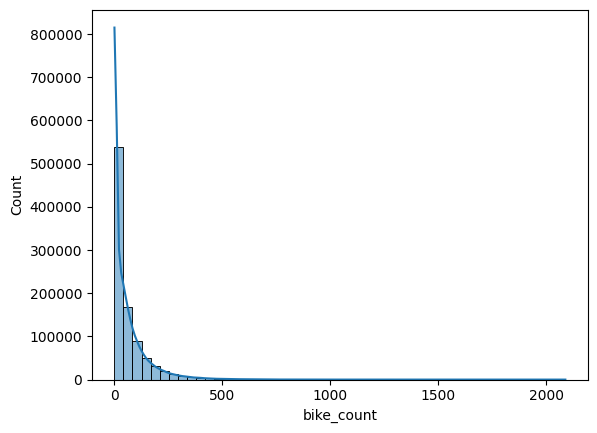

In [14]:
import seaborn as sns
ax = sns.histplot(df, x='bike_count', kde=True, bins=50)

## Exploratory Data Analysis (EDA)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 936649 entries, 0 to 936648
Data columns (total 10 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   counter_id                 936649 non-null  category      
 1   counter_name               936649 non-null  category      
 2   site_id                    936649 non-null  int64         
 3   site_name                  936649 non-null  category      
 4   bike_count                 936649 non-null  float64       
 5   date                       936649 non-null  datetime64[us]
 6   counter_installation_date  936649 non-null  datetime64[us]
 7   counter_technical_id       930495 non-null  category      
 8   latitude                   936649 non-null  float64       
 9   longitude                  936649 non-null  float64       
dtypes: category(4), datetime64[us](2), float64(3), int64(1)
memory usage: 46.5 MB


In [16]:
df.nunique(axis=0)

counter_id                     97
counter_name                   97
site_id                        70
site_name                      70
bike_count                   1037
date                         9908
counter_installation_date      36
counter_technical_id           69
latitude                       70
longitude                      70
dtype: int64

In [17]:
df.describe()

,site_id,bike_count,date,counter_installation_date,latitude,longitude
count,9.366490e+05,936649.000000,936649,936649,936649.000000,936649.000000
mean,1.032558e+08,61.171178,2021-03-28 09:01:45.511456,2018-11-29 06:11:33.004102,48.855573,2.343569
min,1.000031e+08,0.000000,2020-09-01 01:00:00,2012-02-13 00:00:00,48.820240,2.265420
25%,1.000475e+08,4.000000,2020-12-16 00:00:00,2018-11-28 00:00:00,48.840150,2.314440
50%,1.000560e+08,29.000000,2021-03-29 14:00:00,2019-10-30 00:00:00,48.853720,2.352110
75%,1.000563e+08,82.000000,2021-07-09 08:00:00,2019-12-10 00:00:00,48.865020,2.374720
max,3.000147e+08,2088.000000,2021-10-18 21:00:00,2021-05-18 00:00:00,48.896960,2.409690
std,2.512007e+07,88.034268,NaN,NaN,0.020084,0.037416


Let's look at the most used sites. Note that one can have 2 counters in one site.

In [18]:
df.groupby(['site_name', 'counter_name'], observed=True)['bike_count'].sum().sort_values(
    ascending=False
).head(10).to_frame()

,,bike_count
site_name,counter_name,
Totem 73 boulevard de Sébastopol,Totem 73 boulevard de Sébastopol S-N,2270234.0
Totem 64 Rue de Rivoli,Totem 64 Rue de Rivoli O-E,1775289.0
Totem 73 boulevard de Sébastopol,Totem 73 boulevard de Sébastopol N-S,1724878.0
89 boulevard de Magenta NO-SE,89 boulevard de Magenta NO-SE,1583873.0
102 boulevard de Magenta SE-NO,102 boulevard de Magenta SE-NO,1535096.0
72 boulevard Voltaire NO-SE,72 boulevard Voltaire NO-SE,1367712.0
67 boulevard Voltaire SE-NO,67 boulevard Voltaire SE-NO,1289885.0
72 boulevard Richard Lenoir S-N,72 boulevard Richard Lenoir S-N,1253107.0
Totem 64 Rue de Rivoli,Totem 64 Rue de Rivoli E-O,1189066.0


In [19]:
import folium

m = folium.Map(location=df[['latitude', 'longitude']].mean(axis=0).values, zoom_start=13)

for _, row in df[['counter_name', 'latitude', 'longitude']].drop_duplicates('counter_name').iterrows():
    folium.Marker(
    row[['latitude', 'longitude']].values.tolist(), popup=row['counter_name']
    ).add_to(m)

m

Next we will look into the temporal distribution of the most frequently used bike counters. If we plot it directly we will not see much because there are half a million data points.

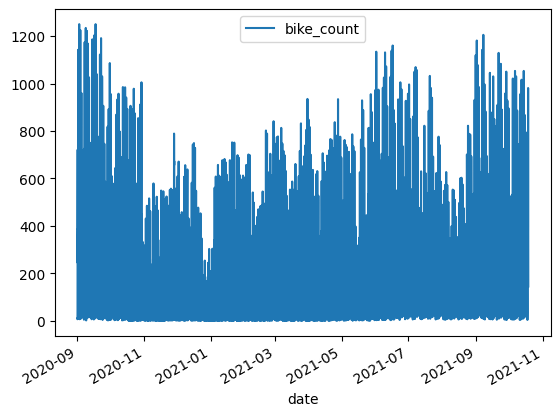

In [20]:
query_str = "counter_name == 'Totem 73 boulevard de Sébastopol S-N'"
_ = df.query(query_str).sort_values('date').plot(x='date', y='bike_count')

Instead we aggregate the data, for instance, by week to have a clearer overall picture.

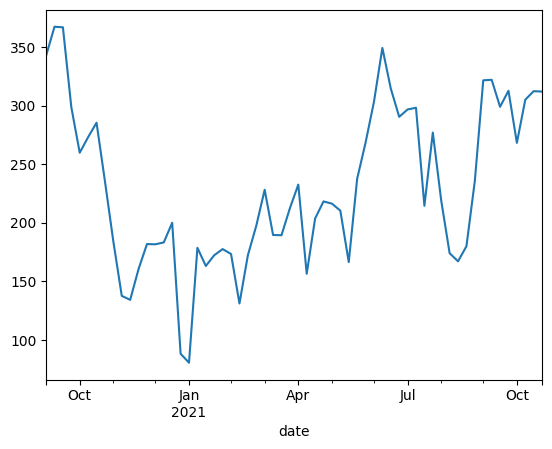

In [21]:
_ = df.query(query_str).groupby(pd.Grouper(freq='1W', key='date'))['bike_count'].mean().plot()

While at the same time, we can zoom on a week in particular for a more short-term visualization:

<Axes: xlabel='date'>

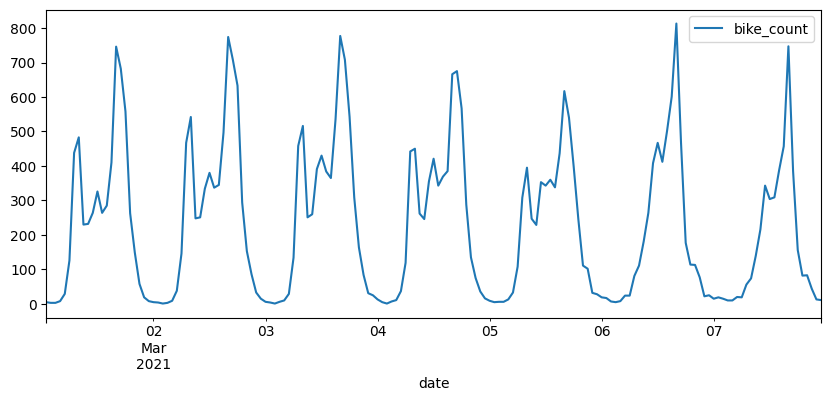

In [22]:
fig, ax = plt.subplots(figsize=(10, 4))
df.query(query_str + " and '2021/03/01' < date < '2021/03/08'").sort_values('date').plot(x='date', y='bike_count', ax=ax)

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>Plot the average bike_count per hour of the week (averaged over all sites).</li>
    </ul>
</div>

You should clearly distinguish the commute patterns in the morning and evenings of the work days
and the leisure use of the bikes on the weekends with a more spread peak demand around the middle of the days.

Solution is in `solutions/04-1-case_study_averaging_per_weekday_hour.py`

## Metrics

There are many possible metrics for regression tasks like here. In what follows we will be using the RMSLE, that penalizes less large deviations than the MLE.

#### Root Mean Squared Logarithmic Error (RMSLE)

RMSLE = $\sqrt{ \frac{1}{N} \sum_{i=1}^N (\log(x_i + 1) - \log(y_i + 1))^2 }$

In what follows we will be using the RMSLE, that penalizes less large deviations than the MSE. For this we will be creating a new column called `log_bike_count` using the `np.log1p` function.

In [23]:
import numpy as np
df['log_bike_count'] = np.log1p(df['bike_count'])

## Feature extraction

In [24]:
def _encode_dates(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the DateOfDeparture columns
    X.loc[:, 'year'] = X['date'].dt.year
    X.loc[:, 'month'] = X['date'].dt.month
    X.loc[:, 'day'] = X['date'].dt.day
    X.loc[:, 'weekday'] = X['date'].dt.weekday
    X.loc[:, 'hour'] = X['date'].dt.hour

    # Finally we can drop the original columns from the dataframe
    return X.drop(columns=["date"])

In [25]:
df['date'].head()

0   2020-09-01 02:00:00
1   2020-09-01 01:00:00
2   2020-09-01 05:00:00
3   2020-09-01 04:00:00
4   2020-09-01 03:00:00
Name: date, dtype: datetime64[us]

In [26]:
_encode_dates(df[['date']].head())

,year,month,day,weekday,hour
0,2020,9,1,1,2
1,2020,9,1,1,1
2,2020,9,1,1,5
3,2020,9,1,1,4
4,2020,9,1,1,3


In [27]:
from sklearn.preprocessing import FunctionTransformer

date_encoder = FunctionTransformer(_encode_dates, validate=False)
date_encoder.fit_transform(df[['date']]).head()

,year,month,day,weekday,hour
0,2020,9,1,1,2
1,2020,9,1,1,1
2,2020,9,1,1,5
3,2020,9,1,1,4
4,2020,9,1,1,3


## Train and test data

We will now focus on one site and focus on the forecast of its bike count.

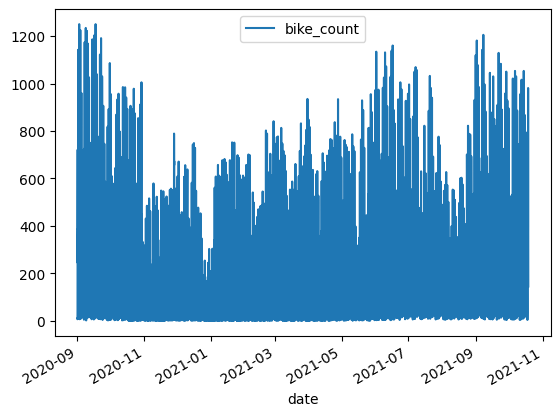

In [28]:
counter_name = 'Totem 73 boulevard de Sébastopol S-N'

data = df.query("counter_name == @counter_name").sort_values('date')
data.plot(x='date', y="bike_count");

In [29]:
X, y = data.drop(['bike_count', 'log_bike_count'], axis='columns'), data['log_bike_count']
X = X[['date']]

In [30]:
n_samples_train = len(X) // 2
X_train, y_train = X[:n_samples_train], y.iloc[:n_samples_train]
X_test, y_test = X[n_samples_train:], y.iloc[n_samples_train:]

In [31]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

date_encoder = FunctionTransformer(_encode_dates)
regressor = Ridge()
selector = FunctionTransformer(
    lambda X: X[['weekday', 'hour']]
)
ohe = OneHotEncoder(handle_unknown='ignore')

pipe = make_pipeline(date_encoder, selector, ohe, regressor)
pipe.fit(X_train, y_train)

,steps,"[('functiontransformer-1', ...), ('functiontransformer-2', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,func,<function _en...x79c17b432c00>
,inverse_func,None
,validate,False
,accept_sparse,False
,check_inverse,True
,feature_names_out,None
,kw_args,None


In [32]:
from sklearn.metrics import root_mean_squared_error

print(f'Train set, RMSE={root_mean_squared_error(y_train, pipe.predict(X_train)):.2f}')
print(f'Test set, RMSE={root_mean_squared_error(y_test, pipe.predict(X_test)):.2f}')

Train set, RMSE=0.71
Test set, RMSE=0.87


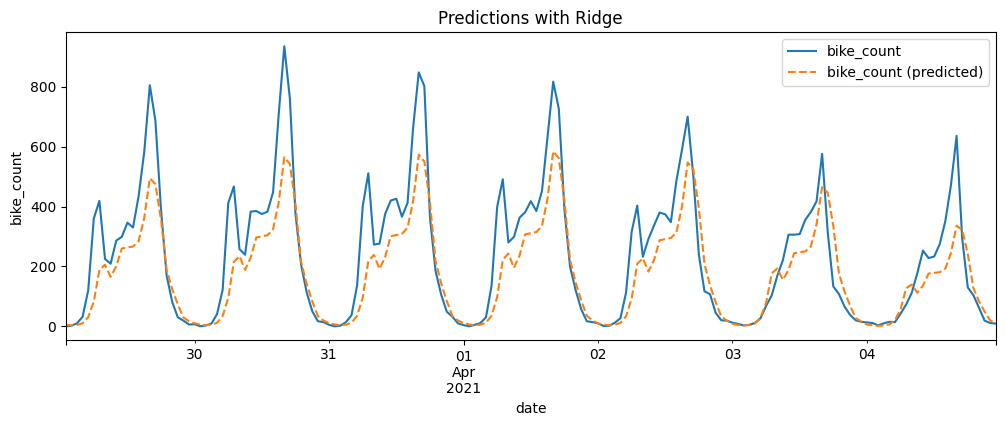

In [33]:
mask = ((X_test['date'] > pd.to_datetime('2021/03/29'))
        & (X_test['date'] < pd.to_datetime('2021/04/05')))

df_viz = X_test.loc[mask].copy()
df_viz['bike_count'] = np.exp(y_test[mask.values]) - 1
df_viz['bike_count (predicted)'] = np.exp(pipe.predict(X_test[mask])) -  1

fig, ax = plt.subplots(figsize=(12, 4))
df_viz.plot(x='date', y='bike_count', ax=ax)
df_viz.plot(x='date', y='bike_count (predicted)', ax=ax, ls='--')
ax.set_title('Predictions with Ridge')
ax.set_ylabel('bike_count');

We can see the daily trend, and some of the week day differences are accounted for, however we still miss the details and the spikes in the morning and the evening are under-estimated.

A useful way to visualize the error is to plot y_pred as a function of y_true,

<Axes: xlabel='y_true', ylabel='y_pred'>

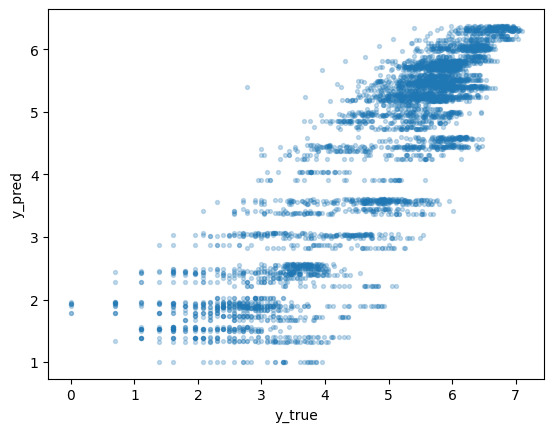

In [34]:
fig, ax = plt.subplots()
df_viz = pd.DataFrame({'y_true': y_test, 'y_pred': pipe.predict(X_test)})
df_viz.plot.scatter(x="y_true", y="y_pred", s=8, alpha=0.25, ax=ax)

Now let's do a proper cross-validation with `TimeSeriesSplit`:

In [35]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

cv = TimeSeriesSplit(n_splits=6)

# When using a scorer in scikit-learn it always needs to be better when smaller, hence the minus sign.
scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='neg_root_mean_squared_error')
print('RMSE: ', -scores)
print(f'RMSE (all folds): {-scores.mean():.3} ± {(-scores).std():.3}')

RMSE:  [0.89948986 1.05809915 0.86807233 0.88715782 0.60939567 0.46923826]
RMSE (all folds): 0.799 ± 0.198


<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>Modify the _encode_dates function to take into account the French holidays. And reevaluate the full pipeline above. Does it help significantly?</li>
    </ul>
</div>

Solution is in `solutions/04-2-french_holidays.py`

In [36]:
from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday, EasterMonday, Easter
from pandas.tseries.offsets import Day, CustomBusinessDay

class FrBusinessCalendar(AbstractHolidayCalendar):
    """ Custom Holiday calendar for France based on
        https://en.wikipedia.org/wiki/Public_holidays_in_France
      - 1 January: New Year's Day
      - Moveable: Easter Monday (Monday after Easter Sunday)
      - 1 May: Labour Day
      - 8 May: Victory in Europe Day
      - Moveable Ascension Day (Thursday, 39 days after Easter Sunday)
      - 14 July: Bastille Day
      - 15 August: Assumption of Mary to Heaven
      - 1 November: All Saints' Day
      - 11 November: Armistice Day
      - 25 December: Christmas Day
    """
    rules = [
        Holiday('New Years Day', month=1, day=1),
        EasterMonday,
        Holiday('Labour Day', month=5, day=1),
        Holiday('Victory in Europe Day', month=5, day=8),
        Holiday('Ascension Day', month=1, day=1, offset=[Easter(), Day(39)]),
        Holiday('Bastille Day', month=7, day=14),
        Holiday('Assumption of Mary to Heaven', month=8, day=15),
        Holiday('All Saints Day', month=11, day=1),
        Holiday('Armistice Day', month=11, day=11),
        Holiday('Christmas Day', month=12, day=25)
    ]

cal = FrBusinessCalendar()



<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>Add interaction terms between one-hot encoded hour and weekdays in your model using <code>sklearn.preprocessing.PolynomialFeatures</code>. Does it help?</li>
    </ul>
</div>

Solution is in `solutions/04-3-polynomial_features.py`

## Patch-based approaches: the AR model

So far we have only explored non-recurrent forecasting models.
Another approach is to consider a recurrent model, which learns $p(x_{t+1}| x_t, ... x_{t-p})$ and use this model by reinjecting the predicted value to predict $x_{t+2}$.

Let us illustrate this concept on a simple example, where the time-series is $x_t = t$.

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import hankel

p = 3
x = np.arange(1, 25)
x

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])

we can for a model with all windows of length $p=3$ to learn the next value.
This amounts to extracting all windows of length 3 in the signal:

In [38]:
X = hankel(x, r=np.zeros(p))[:-p]
X

array([[ 1.,  2.,  3.],
       [ 2.,  3.,  4.],
       [ 3.,  4.,  5.],
       [ 4.,  5.,  6.],
       [ 5.,  6.,  7.],
       [ 6.,  7.,  8.],
       [ 7.,  8.,  9.],
       [ 8.,  9., 10.],
       [ 9., 10., 11.],
       [10., 11., 12.],
       [11., 12., 13.],
       [12., 13., 14.],
       [13., 14., 15.],
       [14., 15., 16.],
       [15., 16., 17.],
       [16., 17., 18.],
       [17., 18., 19.],
       [18., 19., 20.],
       [19., 20., 21.],
       [20., 21., 22.],
       [21., 22., 23.]])

We have our features $X$, now we need the target variable $y$:

*Note:* We work so that the number of samples is kept constant.
It's a hard constraint of scikit-learn that any transformation
to data keeps the number of samples fixed.

In [39]:
y = x[p:]
y

array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 23, 24])

In [40]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X, y)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [41]:
def forecast(model, x, n_samples, order=None):
    if order is None:
        order = model.coef_.shape[0]
    y_pred = np.empty(n_samples + order)  # the prediction
    y_pred[:order] = x[-order:]
    for i in range(n_samples):  # now predict successively one sample at a time
        y_pred[i + order] = model.predict(y_pred[i:i + order][None, :])[0]
    return y_pred[order:]

x_forecast = forecast(model, x, 10)
x_forecast

array([25., 26., 27., 28., 29., 30., 31., 32., 33., 34.])

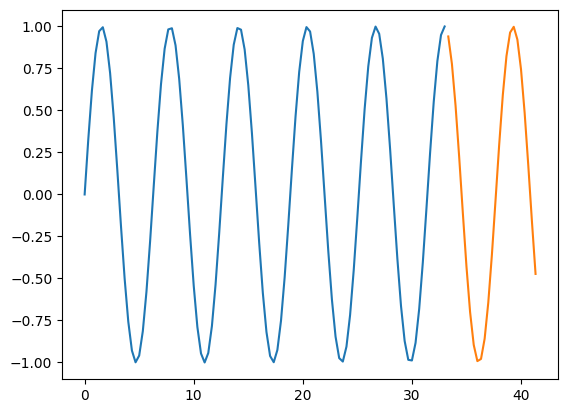

In [42]:
T = 100
t = np.arange(T) / 3
x = np.sin(t)
X, y = hankel(x, r=np.zeros(p))[:-p], x[p:]

model = LinearRegression()
model.fit(X, y)

H = 25
t_next = np.arange(T, T+H) / 3
x_forecast = forecast(model, x, H)

plt.plot(t, x)
plt.plot(t_next, x_forecast)

<div class="alert alert-success">
    <b>EXERCISE</b>:
    Compare the performance of an auto-regressive (AR) Ridge model with an AR model based on RandomForest
     <ol>
      <li>Form the training dataset <code>X_ar, y_ar</code> as hankel matrices from the signal we want to predict and the next time point.</li>
      <li>Train a <code>Ridge</code> model and a <code>RandomForestRegressor</code> with these training set.</li>
      <li>Predict the bike demand using the <code>forecast</code> function.</li>
      <li>Evalute the forecasted series with the <code>root_mean_square_error</code> and plot the forecast for the week of the 5th to the 12th April 2021.</li>
    </ol>
    
<i>Hint:</i> Use an AR model of order $p=167$ for a week.
    
</div>

Solution are in `solutions/04-4-forecast-ridge.py` and `solutions/04-4-forecast-rf.py`

In [ ]:
§load solutions/04-forecast-ridge.py

We can perform a cross validation with the following code:


In [ ]:
scores = []
for idx_train, idx_test in cv.split(X_train):
    X_ar, y_ar = hankel(y_train.iloc[idx_train].values, r=np.zeros(p))[:-p], y_train.iloc[idx_train].values[p:]
    model = Ridge().fit(X_ar, y_ar)
    y_forecast = forecast(model, y_ar, len(idx_test), p)
    scores.append(root_mean_squared_error(y_train.iloc[idx_test].values, y_forecast))

scores = np.array(scores)
print('RMSE: ', scores)
print(f'RMSE (all folds): {scores.mean():.3} ± {(scores).std():.3}')

# Using recent advances with Time-series Foundation Models

As discussed with Tabular foundation models, recent trends is to replace learning a model with foundation models doing in context learning.
This trend has also started on Time-series forecasting with various Time-Series Foundation models (TSFM) which have been proposed in 2025.
Here we describe how to use 2 of them on our problem.

## Example 1 — TiRex (NX-AI)

TiRex is a compact, zero-shot forecasting foundation model based on xLSTM.
It accepts a history window and produces point and quantile forecasts
without training on the new dataset.


In [ ]:
! pip install tirex-ts

In [ ]:
import torch
from tirex import load_model

# 1. Load the pre-trained TiRex model
# We use the base model "NX-AI/TiRex".
# If you don't have a GPU, it will fallback to CPU (may be slower for long contexts).
device = "cuda" if torch.cuda.is_available() else "cpu"
tirex_model = load_model("NX-AI/TiRex", device=device)

# 2. Prepare Data
# TiRex expects a torch tensor of shape (batch_size, sequence_length)
# We convert our context data (raw values) to a float32 tensor and add a batch dimension
context_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(0)
context_tensor = context_tensor.to(device)

# 3. Generate Forecast
# TiRex returns a tuple: (quantiles, mean_prediction)
# quantiles shape: (batch, prediction_length, num_quantiles)
# mean shape: (batch, prediction_length)
with torch.no_grad():
    _, forecast_tirex = tirex_model.forecast(
        context=context_tensor,
        prediction_length=len(y_test)
    )

# Extract the mean forecast for the first (and only) batch item and move to CPU
tirex_pred = forecast_tirex[0].cpu().numpy()

# Plotting
df_viz = X_test.loc[mask].copy()
df_viz['bike_count'] = np.exp(y_test[mask.values]) - 1
df_viz['bike_count (predicted)'] = np.exp(tirex_pred[mask]) -  1

fig, ax = plt.subplots(figsize=(12, 4))
df_viz.plot(x='date', y='bike_count', ax=ax)
df_viz.plot(x='date', y='bike_count (predicted)', ax=ax, ls='--')
ax.set_title('Predictions with Ridge')
ax.set_ylabel('bike_count');

In [ ]:
scores = []
for idx_train, idx_test in cv.split(X_train):
    print(f" Scoring fold {len(scores) + 1}")
    context = torch.tensor(y_train.iloc[idx_train].values, dtype=torch.float32, device=device).unsqueeze(0)
    with torch.no_grad():
        _, forecast_tirex = tirex_model.forecast(
            context=context_tensor,
            prediction_length=len(idx_test)
        )
    y_forecast = forecast_tirex[0].cpu().numpy()
    scores.append(root_mean_squared_error(y_train.iloc[idx_test].values, y_forecast))

scores = np.array(scores)
print('RMSE: ', scores)
print(f'RMSE (all folds): {scores.mean():.3} ± {(scores).std():.3}')

## Example 2 -- Chronos (Amazon)

Chronos (based on T5) treats time-series values as a language of tokens. It is highly robust for univariate forecasting.

In [ ]:
!pip install chronos-forecasting

In [ ]:
import torch
import numpy as np
from chronos import ChronosPipeline

# 1. Load the pre-trained Chronos model (using 'small' variant)
device = "cuda" if torch.cuda.is_available() else "cpu"
chronos_pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map=device,
    dtype=torch.float32,
)

# 2. Prepare Data
# Chronos expects a tensor of shape (num_series, sequence_length)
context_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(0)

# 3. Generate Forecast
# pipeline.predict returns samples of shape (num_series, num_samples, prediction_length)
forecast_samples = chronos_pipeline.predict(context_tensor, len(y_test))

# Extract the median forecast as the point prediction
chronos_pred = torch.quantile(forecast_samples, 0.5, dim=1).squeeze(0).numpy()

# Plotting (Matching your visualization style)
df_viz_chronos = X_test.loc[mask].copy()
df_viz_chronos['bike_count'] = np.exp(y_test[mask.values]) - 1
df_viz_chronos['bike_count (predicted)'] = np.exp(chronos_pred[mask]) - 1

fig, ax = plt.subplots(figsize=(12, 4))
df_viz_chronos.plot(x='date', y='bike_count', ax=ax, label='Actual')
df_viz_chronos.plot(x='date', y='bike_count (predicted)', ax=ax, ls='--', label='Chronos (Zero-Shot)')
ax.set_title('Amazon Chronos: Zero-Shot Forecast')
ax.set_ylabel('bike_count')
plt.legend()
plt.show()

In [ ]:
scores_chronos = []
for idx_train, idx_test in cv.split(X_train):
    print(f" Scoring fold {len(scores_chronos) + 1} with Chronos...")
    context = torch.tensor(y_train.iloc[idx_train].values, dtype=torch.float32).unsqueeze(0)
    
    with torch.no_grad():
        forecast = chronos_pipeline.predict(context, len(idx_test))
    
    y_forecast = torch.quantile(forecast, 0.5, dim=1).squeeze(0).numpy()
    scores_chronos.append(root_mean_squared_error(y_train.iloc[idx_test].values, y_forecast))

scores_chronos = np.array(scores_chronos)
print('Chronos RMSE: ', scores_chronos)
print(f'RMSE (all folds): {scores_chronos.mean():.3} ± {(scores_chronos).std():.3}')